In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
#DATA GENERATION
def createDataPoints(centroidLocation, numSamples, clusterDeviation):
    #Create random data and store in feature matrix X and response vector y.
    X, y = make_blobs(n_samples=numSamples, centers=centroidLocation, 
                                cluster_std=clusterDeviation)
    #Standardize features
    X = StandardScaler().fit_transform(X)
    return X, y

In [5]:
X, y = createDataPoints([[4,3], [2,-1], [-1,4]] , 1500, 0.5)

In [6]:
#Modeling
epsilon = 0.3
minimumSamples = 7
db = DBSCAN(eps=epsilon, min_samples= minimumSamples).fit(X)
labels = db.labels_
labels

array([0, 1, 2, ..., 0, 1, 0], dtype=int64)

In [7]:
#Distingush Outliers
# Firts, create an array of booleans using the labels from db.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_
# Remove repetition in labels by turning it into a set.
unique_labels = set(labels)
unique_labels

{-1, 0, 1, 2}

In [8]:
#Data Visualization
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

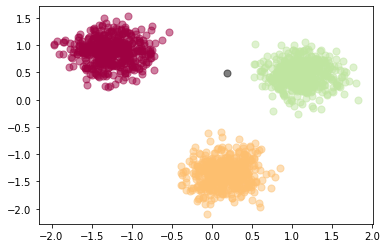

In [9]:
# Plot the points with colors
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    # Plot the datapoints that are clustered
    xy = X[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

    # Plot the outliers
    xy = X[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

In [13]:
#APPLYING KMEANS ON THE SAME DATA
from sklearn.cluster import KMeans
k_means = KMeans(init = "k-means++", n_clusters = 3, n_init = 12)
k_means.fit(X)

KMeans(n_clusters=3, n_init=12)

In [14]:
k_means_labels = k_means.labels_
k_means_labels

array([1, 2, 0, ..., 1, 2, 1])

In [15]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[ 1.10455861,  0.46390895],
       [-1.26081212,  0.89059552],
       [ 0.15625352, -1.35450447]])

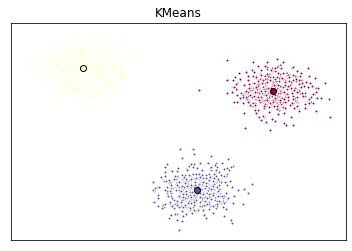

In [16]:
#CREATING THE VISUAL PLOT
#Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

#Colors uses a color map, which will produce an array of colors based on
#the number of labels there are. We use set(k_means_lables)
#unique lables

colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

#Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-3, which will match the possible clusters that each data
# point is in.

for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):
    
    #Create a list of all data points, where the data points that are
    #in the cluster(ex. cluster 0) are labeled as true, else they are
    #labeled as false.
    my_members = (k_means_labels == k)
    
    #Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    #Plots the datapoints with color col.
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor = col, marker = '.')
    
    #Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

#Title of the plot
ax.set_title('KMeans')

#Remove x-axis ticks
ax.set_xticks(())

#Remove y-axis ticks
ax.set_yticks(())

#Show the plot
plt.show()

Weather Station Clustering using DBSCAN & scikit-learn 
DBSCAN is especially very good for tasks like class identification in a spatial context. The wonderful attribute of DBSCAN algorithm is that it can find out any arbitrary shape cluster without getting affected by noise. For example, this following example cluster the location of weather stations in Canada. <Click 1> DBSCAN can be used here, for instance, to find the group of stations which show the same weather condition. As you can see, it not only finds different arbitrary shaped clusters, can find the denser part of data-centered samples by ignoring less-dense areas or noises.

Let's start playing with the data. We will be working according to the following workflow:

Loading data
Overview data
Data cleaning
Data selection
Clusteing

# Weather Station Clustering using DBSCAN & scikit-learn

In [17]:
import csv
import pandas as pd
import numpy as np

data = pd.read_csv("weather-stations20140101-20141231.csv")
data.head()

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DISCOVERY ISLAND,48.425,-123.226,BC,NaN,NaN,NaN,12.5,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012475
4,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573


In [18]:
#Cleaning
data = data[pd.notnull(data["Tm"])]
data = data.reset_index(drop=True)
data.head()

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573
4,ESQUIMALT HARBOUR,48.432,-123.439,BC,8.8,0.0,NaN,13.1,0.0,1.9,...,8.0,NaN,NaN,12.0,NaN,NaN,NaN,258.6,0.0,1012710


In [21]:
#Visualization
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

llon=-140
ulon=-50
llat=40
ulat=65

data = data[(data['Long'] > llon) & (data['Long'] < ulon) & (data['Lat'] > llat) &(data['Lat'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
# my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations        

xs,ys = my_map(np.asarray(data.Long), np.asarray(data.Lat))
data['xm']= xs.tolist()
data['ym'] =ys.tolist()

#Visualization1
for index,row in data.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)
#plt.text(x,y,stn)
plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [22]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = data[['xm','ym']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.15, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
data["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
data[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)

KeyError: "None of [Index(['xm', 'ym'], dtype='object')] are in the [columns]"

In [23]:
set(labels)

{-1, 0, 1, 2}

In [24]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))


ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [25]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = pdf[['xm','ym','Tx','Tm','Tn']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
pdf["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


NameError: name 'pdf' is not defined

In [26]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'